In [209]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from torch.distributions.utils import logits_to_probs

from sklearn import linear_model
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam

from src.utils import load_data

### Load data

In [210]:
X, y, k = load_data()
print(X.head())
X = X.values
y = y.values
print('X-shape: {}, y-shape: {}'.format(X.shape, y.shape)) 

   youth_pop_5to18  commute_priv_vehicle  med_hhincome  avg_ann_daily_traffic  \
0              894              0.634634         74837                 8682.0   
1             1158              0.494977         77991                16917.0   
2             1120              0.422405         32354                22712.0   
3              281              0.199795         34635               124767.0   
4             1998              0.286795         23423                10219.0   

   fragment_index  TotalPop   Men  Women  Hispanic  White  ...  Transit  Walk  \
0       -3.061385      5403  2659   2744      75.8    2.3  ...     38.6   2.9   
1       -2.915361      5915  2896   3019      62.7    3.6  ...     44.6   1.4   
2       -0.227456      5879  2558   3321      65.1    1.6  ...     45.5   8.6   
3        3.029461      2591  1206   1385      55.4    9.0  ...     63.9   3.0   
4        0.165237      8516  3301   5215      61.1    1.6  ...     68.2   4.3   

   OtherTransp  WorkAtHome

##### Prepare data for model.

In [211]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

##### Baseline linear regression

In [212]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
k_train = k[ix_train]
k_test = k[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

# create and fit logistic regression model
logreg = linear_model.LinearRegression()
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("first 5 predictions:", y_hat[:5])
print("first 5 true values:", y_test[:5])

# evaluate prediction accuracy
print("MSE:", sum((y_hat - y_test)**2)/len(y_hat))

num train: 1382
num test: 713
first 5 predictions: [ 3.66531802  8.51319484 10.03699891  4.84387705  6.42243343]
first 5 true values: [8 3 7 2 0]
MSE: 36.77822935669557


### Define model

**Generative Process**
<ol>
    <li> Draw parameter $r \sim \text{Gamma}(\alpha, \beta)$ . </li>
    <li> Draw parameter $\sigma \sim \text{HalfCauchy}(1)$. </li>
    <li> For each group $k \in \{1, \dots, K\}$ </li>
    <ol>
        <li> Draw linear coefficients $\beta_k \sim N(\beta|\textbf{0},\lambda\textbf{I})$</li>
    </ol>
    <li> For the i'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n | \beta_{k_n}^T\textbf{X}'_n+f_{\text{nnet}}(\textbf{X}^*_n), \sigma^2)$</li>
        <li> OR Draw $\psi_n \sim N(\psi_n | \beta_{k_n}^T\textbf{X}'_n, \sigma^2)$</li>
        <li> Compute $p_n$. </li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

We could also try to fit an $r_k$ for each group.


In [213]:
def hierarchical_model(X, k, n_k, obs=None):
    
    # Number of observations
    N, n_feat = X.shape
    
    # Hyperparameters
    r_gamma1 = 0.5
    r_gamma2 = 1
    beta_mu = 0
    beta_sigma = 1

    # Draw parameters.
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2).to_event())
    sigma = pyro.sample("sigma", dist.HalfCauchy(1).to_event())
    
    with pyro.plate("group", n_k):
        # Draw the parameters for each group
        beta = pyro.sample(
            "beta",
            dist.Normal(beta_mu*torch.ones(n_feat), beta_sigma*torch.ones(n_feat)).to_event()
        )

        
    with pyro.plate("data", N):
        psi_mu = torch.matmul(X, beta[k].transpose(0,1)).diag() # Pretty stupid code beta[k][i] * X[i] for all i
        psi = pyro.sample("psi", dist.Normal(psi_mu, sigma))
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
    
    return pred


In [214]:
# Prepare data for Pyro model
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
k_train = torch.tensor(k_train).long() # these are indices, therefore they need to be (long) integers
n_k = len(np.unique(k))

In [222]:
%%time

# Define guide function.
guide = AutoDiagonalNormal(hierarchical_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 1500

# Setup the optimizer.
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=3)
svi = SVI(hierarchical_model, guide, optimizer, loss=elbo)

# Do gradient steps.
for step in range(n_steps):
    elbo = svi.step(X_train, k_train, n_k, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 17916.5
[500] ELBO: 4792.4
[1000] ELBO: 4627.3
CPU times: user 3min 20s, sys: 2.22 s, total: 3min 23s
Wall time: 34.1 s


##### Visualizations of variable differences from county to county

In [223]:
from pyro.infer import Predictive

predictive = Predictive(hierarchical_model, guide=guide, num_samples=2000,
                        return_sites=("beta", "r", "pred"))
samples = predictive(X_train, k_train, n_k, y_train)

In [224]:
beta_samples = samples["beta"].detach().numpy()
r_samples = samples["r"].detach().numpy()
preds_samples = samples["pred"].detach().numpy()

/Users/jjn/miniconda3/envs/mbased-ml/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jjn/miniconda3/envs/mbased-ml/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jjn/miniconda3/envs/mbased-ml/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

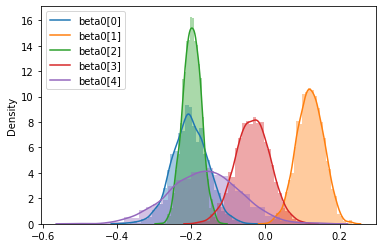

In [225]:
beta_index = 2

for k in range(n_k):
    sns.distplot(beta_samples[:,k,beta_index])
plt.legend(["beta0[%d]" % c for c in range(n_k)])
plt.show()

##### MSE for model

In [226]:
beta = beta_samples.mean(axis=0)
r = r_samples.mean(axis=0)
psi = (beta[k_test] @ X_test.T).diagonal()
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
# evaluate prediction accuracy
print("MSE:", sum((y_hat - y_test)**2)/len(y_hat))

MSE: 194.22737033565105
